<h1><center>Introduction to quantum science and technology - QUANT 400</center></h1>

<p><center> <b>Lecturer:</b> <i>Prof. G. Carleo</i> </center><p>
    
<p><center> <b>Assistant: </b> <i>friederike.metz@epfl.ch

## Exercise 3 - Variational quantum algorithms

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.circuit import ParameterVector

### Parameterized quantum circuits in Qiskit

We have already encountered examples of parameterized gates in Qiskit like the `rx` or `rzz` gates.

In [2]:
circ = QuantumCircuit(2)
circ.rx(0.12, 0)
circ.rzz(0.34, 0, 1)
circ.rz(0.56, 1)
circ.draw('mpl')

In the example above we specified the value of the parameter (the angle) directly when constructing the circuit. However, there might be cases where we want to keep the parameters as free variables. For example, imagine you want to run the same circuit many times with different parameters. Then, it makes sense to define the circuit only once with parameters unspecified and only assign the actual values to the parameters when executing the circuit.

We can define parameterized circuits in Qiskit using a parameter placeholder.

In [3]:
dummy_params = ParameterVector("theta", 3) # 3 parameters
dummy_params_iter = iter(dummy_params)
circ = QuantumCircuit(2)
circ.rx(next(dummy_params_iter), 0)
circ.rzz(next(dummy_params_iter), 0, 1)
circ.rz(next(dummy_params_iter), 1)
circ.draw('mpl')

When we run the circuit to, for example, compute an expecation value, we need to pass the actual parameter values to the `Estimator().run` method.

In [4]:
estimator = StatevectorEstimator()

params = [0.12, 0.34, 0.56]

observable = SparsePauliOp.from_list([("ZZ", 1.0)])

pub = (circ, [observable], [params])
result = estimator.run(pubs=[pub]).result()
result[0].data.evs

array([0.99280864])

We can also conveniently execute the circuit in parallel for different parameter settings.

In [5]:
params2 = [1.2, 3.4, 5.6]

pub = (circ, [observable], [params, params2])
result = estimator.run(pubs=[pub]).result()
result[0].data.evs

array([0.99280864, 0.36235775])

If you want to assign parameters to a predefined circuit yourself, you can use the `assign_parameters` method.

In [6]:
# Statevector(circ) # this does not work because the circuit is abstractely defined without parameters

# first assign the parameters to the circuit
circ2 = circ.assign_parameters(params2)
Statevector(circ2).data.reshape(-1)

array([-0.17397728+0.80679042j, -0.50321353-0.25611964j,
        0.        +0.j        ,  0.        +0.j        ])

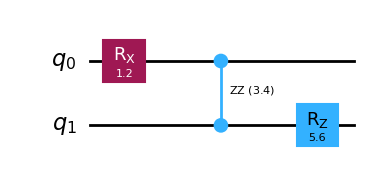

In [7]:
circ2.draw('mpl')

### Problem: Finding ground states with the Variational Quantum Eigensolver (VQE)

In this exercise our goal is to implement the VQE algorithm which allows us to prepare the ground state of a given Hamiltonian on a quantum device. So far, we have always considered the Ising model as an example. To mix things up this time, we will study another paradigmatic spin Hamiltonian: the spin-1/2 Heisenberg chain

$$ H = J \sum_{i=1}^{N-1} \vec{S}_i \cdot \vec{S}_{i+1} =  \frac{J}{4} \sum_{i=1}^{N-1} X_i X_{i+1} + Y_i Y_{i+1} + Z_i Z_{i+1} .$$

The Hamiltonian above is actually the isotropic Heisenberg model, since the coupling constant is the same in all three spatial directions. Therefore, the model above is also called the XXX Heisenberg chain.

We will study the XXX model on an open chain with positive exchange interaction $J$ for which the system's ground state is antiferromagnetic.

a) Define a function that returns the Heisenberg Hamiltonian as a `SparsePauliOp`.

In [8]:
def heisenberg(N, J):
    h_terms = [("XX", [i, i+1], J/4) for i in range(N-1)]
    h_terms += [("YY", [i, i+1], J/4) for i in range(N-1)]
    h_terms += [("ZZ", [i, i+1], J/4) for i in range(N-1)]
    return SparsePauliOp.from_sparse_list(h_terms, num_qubits=N)

VQE is based on a parameterized quantum circuit $U(\theta)$, whose parameters are optimized such that the energy is minimized, i.e.,

$$\min_\theta E(\theta)= \min_\theta \langle 0| {U}^{\dagger}(\theta) H {U}(\theta)|0\rangle .$$

If we optimize all the way to the exact ground state energy then the quantum state at the end of the circuit $|\psi\rangle = {U}(\theta_{opt})|0\rangle$ is the exact ground state of $H$.

The parameterized quantum circuit is also often referred to as an ansatz (for the ground state in this case). Coming up with a good parameterized quantum circuit ansatz is a difficult task and often done heuristically. A common choice is the hardware-efficient ansatz which is composed of a layer of parameterized single-qubit rotations and a layer of fixed, two-qubit entangling gates.

b) Define a function that implements the following circuit. `reps` refers to the number of repetitions of the subcircuit.

<div>
<img src="ansatz.png" width="500"/>
</div>

In [9]:
def hardware_efficient_ansatz(N, reps=1):
    circ = QuantumCircuit(N)
    dummy_params = iter(ParameterVector("theta", 3*N*(reps+1)))
    for _ in range(reps):
        for i in range(N):
            circ.rz(next(dummy_params), i)
            circ.ry(next(dummy_params), i)
            circ.rz(next(dummy_params), i)
        for i in range(N-1):
            circ.cx(i, i+1)
    for i in range(N):
        circ.rz(next(dummy_params), i)
        circ.ry(next(dummy_params), i)
        circ.rz(next(dummy_params), i)
    return circ

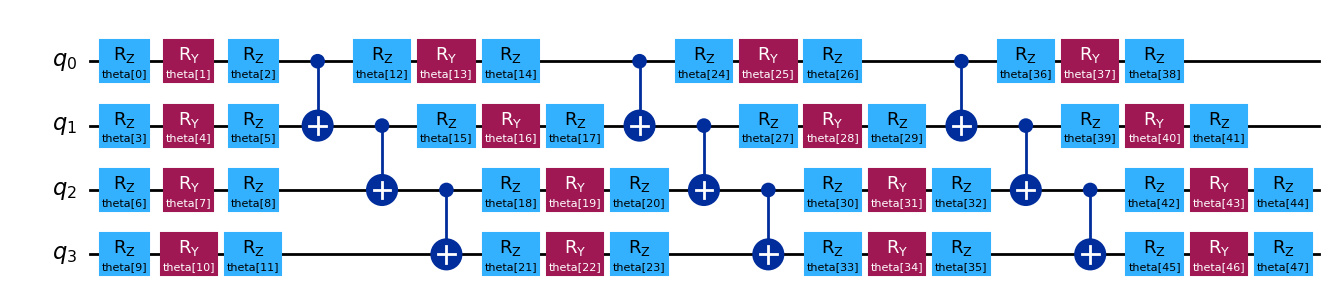

In [10]:
ansatz = hardware_efficient_ansatz(4, reps=3)
ansatz.draw('mpl')

c) Next define the loss function we want to minimize, i.e., 

$$ \mathcal{L}(\theta)=E(\theta)= \langle 0| {U}^{\dagger}(\theta) H {U}(\theta)|0\rangle .$$

Given a vector of parameters $\theta$, the circuit ansatz $U(\theta)$, the Hamiltonian $H$, and an instance of the `Estimator`, this function should return the value of the loss function (the energy).

In [11]:
def loss_function(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    return energy

We want to optimize the circuit parameters $\theta$ via gradient descent. For that we need to compute the gradient of our loss function w.r.t. the parameters. In the lecture you learned that you can compute gradients via the parameter shift rule

$$\partial_{\theta_k} \mathcal{L}\left(\theta_1, \ldots, \theta_k, \ldots \theta_l\right)=\frac{\mathcal{L}\left(\theta_1, \ldots, \theta_k+\frac{\pi}{2}, \ldots \theta_l\right)-\mathcal{L}\left(\theta_1, \ldots, \theta_k-\frac{\pi}{2}, \ldots \theta_l\right)}{2}$$

d) Compute the gradient of the loss function using the parameter shift rule for each parameter. The function below should return the gradient vector `grad` having the same shape as the parameter vector.

In [12]:
def gradient(params, ansatz, hamiltonian, estimator):
    grad = np.zeros_like(params)
    for j in range(len(params)):
        params_shifted = params.copy()
        params_shifted[j] += np.pi / 2.
        l_p = loss_function(params_shifted, ansatz, hamiltonian, estimator)

        params_shifted = params.copy()
        params_shifted[j] -= np.pi / 2.
        l_m = loss_function(params_shifted, ansatz, hamiltonian, estimator)

        grad[j] = (l_p - l_m) / 2.
    return grad

e) Finally write a function which performs the actual optimization via gradient descent with learning rate `eta`. The number of optimization/iteration steps is specified by `n_iter`.

In [13]:
def optimize(params, ansatz, hamiltonian, estimator, eta=0.2, n_iter=100):
    for i in range(n_iter):
        grad = gradient(params, ansatz, hamiltonian, estimator)
        params = params - eta * grad

        energy = loss_function(params, ansatz, hamiltonian, estimator)
        opt_data_dict["iters"] += 1
        opt_data_dict["params"] = params
        opt_data_dict["energies"].append(energy)
        print(f"Iteration: {opt_data_dict['iters']} [Current energy: {energy}]")

Let's see all of this in action.

f) Run the optimization for the parameters specified below

In [14]:
N = 4 # number of spins/qubits
J = 1. # coupling strength
reps = 2 # number of circuit repetitions

n_params = 3*(reps+1)*N # number of parameters in the ansatz
# technically the initial parameters should be random, but for reproducibility we fix them
initial_params = np.ones(n_params) # initial parameters
# initial_params = 2 * np.pi * np.random.rand(n_params) # initial parameters

# leave this unchanged
opt_data_dict = {
    "params": None,
    "iters": 0,
    "energies": [],
}

hamiltonian = heisenberg(N, J)
ansatz = hardware_efficient_ansatz(N, reps=reps)
estimator = StatevectorEstimator()

optimize(initial_params, ansatz, hamiltonian, estimator, eta=0.2, n_iter=100)

Iteration: 1 [Current energy: -0.006360840764325318]
Iteration: 2 [Current energy: -0.06622448207116632]
Iteration: 3 [Current energy: -0.12693064694809025]
Iteration: 4 [Current energy: -0.18766832765965447]
Iteration: 5 [Current energy: -0.2478244706180555]
Iteration: 6 [Current energy: -0.3071048795153579]
Iteration: 7 [Current energy: -0.36554344512976655]
Iteration: 8 [Current energy: -0.423394705614465]
Iteration: 9 [Current energy: -0.48095707191489834]
Iteration: 10 [Current energy: -0.5383960408040831]
Iteration: 11 [Current energy: -0.595626667088621]
Iteration: 12 [Current energy: -0.6522871499481121]
Iteration: 13 [Current energy: -0.7078024538795862]
Iteration: 14 [Current energy: -0.7615059366318289]
Iteration: 15 [Current energy: -0.812768903357117]
Iteration: 16 [Current energy: -0.8610937827678464]
Iteration: 17 [Current energy: -0.9061534195549665]
Iteration: 18 [Current energy: -0.947787608247029]
Iteration: 19 [Current energy: -0.985979923425518]
Iteration: 20 [Curr

g) Compute the exact ground state energy for comparison

In [15]:
from scipy.sparse.linalg import eigsh

H = hamiltonian.to_matrix(sparse=True)
E_ed, v = eigsh(H, k=4, which="SA", return_eigenvectors=True)
psi_exact = v[:,0]
E_exact = E_ed[0]
E_exact

np.float64(-1.6160254037844397)

In [16]:
fig, ax = plt.subplots()
ax.plot(range(opt_data_dict["iters"]), opt_data_dict["energies"])
ax.axhline(E_exact, color="red", linestyle="--")
ax.set_xlabel("Iterations")
ax.set_ylabel("Energy")
plt.draw()

Is the energy minimized and converges to the exact energy? Do the optimized quantum state and the exact ground state coincide?

h) Compute the fidelity between the quantum state at the end of the optimized circuit w.r.t. the exact state.

$$ F = |\langle \psi_{exact} | U(\theta) |0 \rangle|

In [17]:
optimized_ansatz = ansatz.assign_parameters(opt_data_dict["params"])
psi_vqe = Statevector(optimized_ansatz).data.reshape(-1)
np.abs(psi_vqe.conj().T @ psi_exact)

np.float64(0.9744610946455567)

i) In case the energy/state did not converge to the ground state, we need to do some hyperparameter tuning. What hyperparameters are there? Which hyperparameter(s) do you think we could change to improve convergence to the ground state? Try it out!

Hyperparameters are the learning rate `eta`, the numer of iterations `n_iter`, the number of circuit repetitions `reps`.

One reason we might not be able to learn the ground state to a good accurcay is that the ansatz is not expressive enough, i.e., there is no parameter setting for which the quantum circuit ansatz state corresponds to the true ground state. The expressivity is controlled by the number of parameters which in turn is controlled by the number of circuit repetitions `reps`. Increasing `reps` to 6 already gives a very good approximation to the ground state.

Below I optimize the circuit for different number of circuit repetitions and plot the final energy as a function of `reps`. You clearly see that the accuracy improves as we add more parameters/gates to the circuit.

(Note that the code below takes a minute to run.)

In [18]:
fig, ax = plt.subplots()

optimized_energies = []

for reps in range(1, 6):
    n_params = 3*(reps+1)*N # number of parameters in the ansatz
    initial_params = np.ones(n_params) # initial parameters
    # initial_params = 2 * np.pi * np.random.rand(n_params) # initial parameters

    opt_data_dict = {
        "params": None,
        "iters": 0,
        "energies": [],
    }

    ansatz = hardware_efficient_ansatz(N, reps=reps)
    
    optimize(initial_params, ansatz, hamiltonian, estimator, eta=0.2, n_iter=100)

    ax.plot(range(opt_data_dict["iters"]), opt_data_dict["energies"], label=f"Reps: {reps}")

    optimized_energies.append(opt_data_dict["energies"][-1])

ax.axhline(E_exact, color="red", linestyle="--")
ax.set_xlabel("Iterations")
ax.set_ylabel("Energy")
ax.legend()
plt.draw()


Iteration: 1 [Current energy: 0.4838821446097358]
Iteration: 2 [Current energy: 0.4602097285167303]
Iteration: 3 [Current energy: 0.43357709446014114]
Iteration: 4 [Current energy: 0.40350183081864843]
Iteration: 5 [Current energy: 0.3693829157772993]
Iteration: 6 [Current energy: 0.33046408584289566]
Iteration: 7 [Current energy: 0.28579322166646387]
Iteration: 8 [Current energy: 0.23418550754295678]
Iteration: 9 [Current energy: 0.17420704489159067]
Iteration: 10 [Current energy: 0.10420988256997141]
Iteration: 11 [Current energy: 0.02246787653374023]
Iteration: 12 [Current energy: -0.07252408908798966]
Iteration: 13 [Current energy: -0.18154322027642233]
Iteration: 14 [Current energy: -0.303971257243919]
Iteration: 15 [Current energy: -0.4371954051637524]
Iteration: 16 [Current energy: -0.5764814625803978]
Iteration: 17 [Current energy: -0.7156420470409477]
Iteration: 18 [Current energy: -0.8483483652782591]
Iteration: 19 [Current energy: -0.9694313815306753]
Iteration: 20 [Current 

You see that the purple line, which corresponds to using 5 circuit repetitions, converges very close to the exact ground state energy. Using fewer circuit repetitions leads to a larger deviation to the ground state energy.

Let's plot the final energy at the end of each optimization against the number of circuit repetitions.

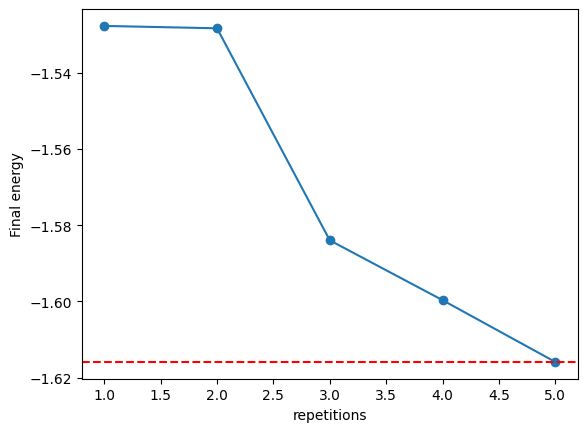

In [19]:
fig, ax = plt.subplots()
ax.plot(range(1,6), optimized_energies, marker="o")
ax.axhline(E_exact, color="red", linestyle="--")
ax.set_xlabel("repetitions")
ax.set_ylabel("Final energy")
plt.draw()

Indeed, with 5 circuit repetitions we get a very good approximation to the ground state energy at the end of the optimization. Hence, the 5-reps circuit is more expressive than a circuit with less repetitions/parameters.

Finally, let's look at the fidelity of the optimized state (of the reps=5 circuit) to the exact ground state. As expected, the state overlap is large and we indeed prepared a state that is very close to the exact ground state.

In [20]:
optimized_ansatz = ansatz.assign_parameters(opt_data_dict["params"])
psi_vqe = Statevector(optimized_ansatz).data.reshape(-1)
np.abs(psi_vqe.conj().T @ psi_exact)

np.float64(0.9999151830709995)